In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from venn import venn

import sys
sys.path.append(os.path.normpath('C:/Users/heineib/Documents/GitHub/sc_seq_analysis/'))
import sc_seq_functions

base_dir = os.path.normpath('C:/Users/heineib/Google Drive/Crick_LMS/projects/9_strains')
data_dir = base_dir + os.sep + 'initial_proteomics'


In [212]:
def make_exp_map(prot_data_cond, mapped_column):
    #Makes a map from gene name to output column from a given proteomics dataframe
    #Mapped column options: 
    # 'Genes.MaxLFQ'
    # 'LFC'
    N_genes = [len(gene.split(';')) for gene in prot_data_cond['Genes']]
    prot_data_cond['N_genes'] = N_genes

    prot_data_cond_grouped = prot_data_cond.groupby('N_genes')
    exp_map = prot_data_cond_grouped.get_group(1).loc[: ,['Genes', mapped_column]]
    assert len(set(exp_map['Genes']))==len(exp_map['Genes']), 'rows with only one gene should be unique'
    exp_map.set_index('Genes', inplace=True)
    exp_map['exp_category']='unique'

    #Assign scores for genes that are not uniquely assigned
    non_unique_N = list(prot_data_cond_grouped.groups.keys())
    non_unique_N.remove(1)

    if len(non_unique_N)>0: 
        for N in non_unique_N: 
            for row in prot_data_cond_grouped.get_group(N).iterrows():
                genes = row[1]['Genes'].split(';')

                #check if it is already present.  
                for gene in genes: 
                    # If so keep original value, label as unique_non_unique
                    ## NOTE: Could change the rule for how to assign value when data is not unique - e.g. take an average.  
                    if gene in exp_map.index: 
                        if not(exp_map.loc[gene, 'exp_category'] in {'unique', 'unique_non_unique'}):
                            print(gene + 'already present from non_unique row.  Used first value encountered')
                            exp_map.loc[gene,'exp_category']='non_unique_mult_group'
                        else: 
                            exp_map.loc[gene, 'exp_category']='unique_non_unique'
                    else:
                        exp_map.loc[gene, mapped_column]=row[1][mapped_column]
                        exp_map.loc[gene,'exp_category'] = 'non_unique'

    assert len(set(exp_map.index))==len(exp_map.index), 'Index should be unique'
    
    return exp_map
    

In [183]:
spec_params = {'Scer': ('30-0008_yeast_sswath_lib_0_005_FDR.genes.tsv'), #('30-0008_NCBI_Sc_genemark_code_0.genes.tsv'),
         'Kmar': ('30-0008_NCBI_Km_genemark_code_0.genes.tsv')
        }

cond_data = {'YPD': {'Scer':'C4', 'Kmar': 'B7', 'fname': 'YPD'}, 
             'SM + 2% Gluc.': {'Scer': 'C1', 'Kmar': 'B5', 'fname':'gluc'}, 
             'SM + 1% Mann. Hypox.': {'Scer': 'A1', 'Kmar': 'A2', 'fname':'mann'}
            }

prot_data = {}


for spec in spec_params.keys(): 
    fname = spec_params[spec]
    prot_data_spec = pd.read_table(data_dir + os.sep + spec + os.sep + fname)
    wells = [data_file.split('\\')[-1].split('_')[-1].split('.')[0] for data_file in prot_data_spec['File.Name']]
    prot_data_spec['well'] = wells
    prot_data[spec] = {}
    for cond in cond_data.keys(): 
        prot_data_spec_cond = prot_data_spec[prot_data_spec['well']==cond_data[cond][spec]]
        prot_data[spec][cond] = prot_data_spec_cond









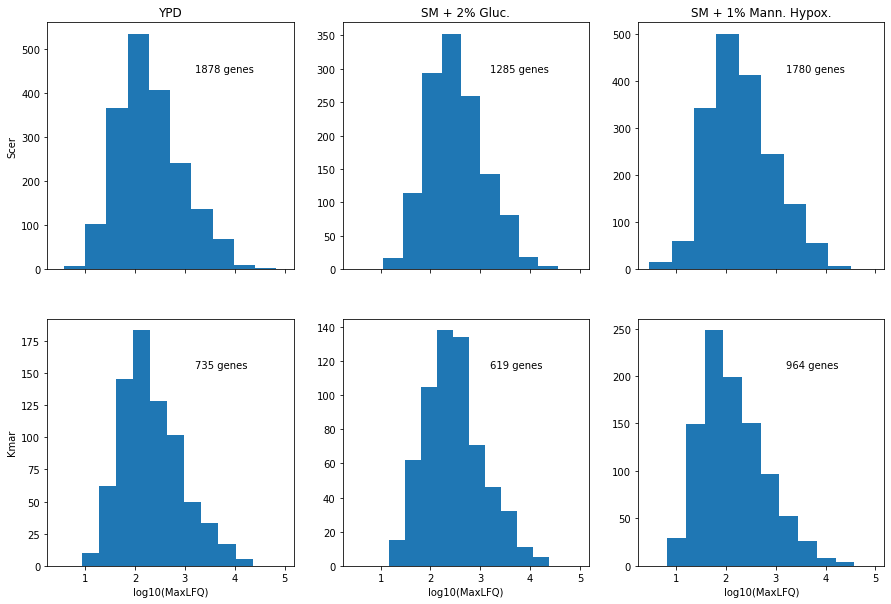

In [10]:

# Histogram with number of genes for each condition
specs = list(spec_params.keys())
conds = list(cond_data.keys())

fig, axarr = plt.subplots(len(specs),len(conds), figsize=(15,10), sharex = True)
for jj, spec in enumerate(specs): 
    for kk, cond in enumerate(conds): 
            ax = axarr[jj][kk]
            data = prot_data[spec][cond]
            ax.hist(np.log10(data['Genes.MaxLFQ']))
            if jj==0: 
                ax.set_title(cond)
            if kk ==0: 
                ax.set_ylabel(spec)
            if jj==1: 
                ax.set_xlabel('log10(MaxLFQ)')
            ax.text(.6,.8,'{} genes'.format(len(data)), transform = ax.transAxes)

# make a dataframe with all genes.

# for each condition

# Calculate the number of genes and plot a histogram



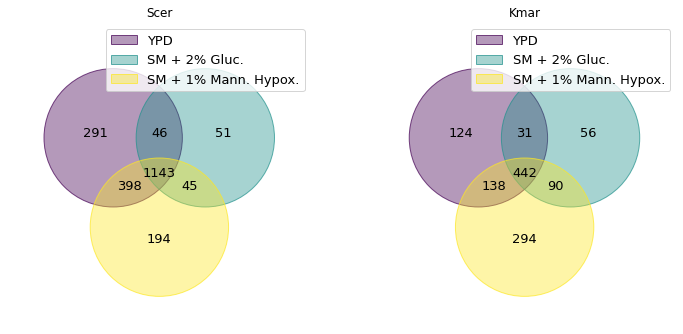

In [11]:
#Venn diagram of shared genes within species
fig, axarr = plt.subplots(1,len(specs), figsize=(12,8))


for jj, spec in enumerate(specs): 
    ax = axarr[jj]
    genenames = {}
    for cond in conds: 
        data = prot_data[spec][cond]
        genenames[cond] = set(list(data['Genes']))
    venn(genenames, ax=ax)
    ax.set_title(spec)
    
#Scatter plots within species

#Fold Change within species

#Map genenames to normal names

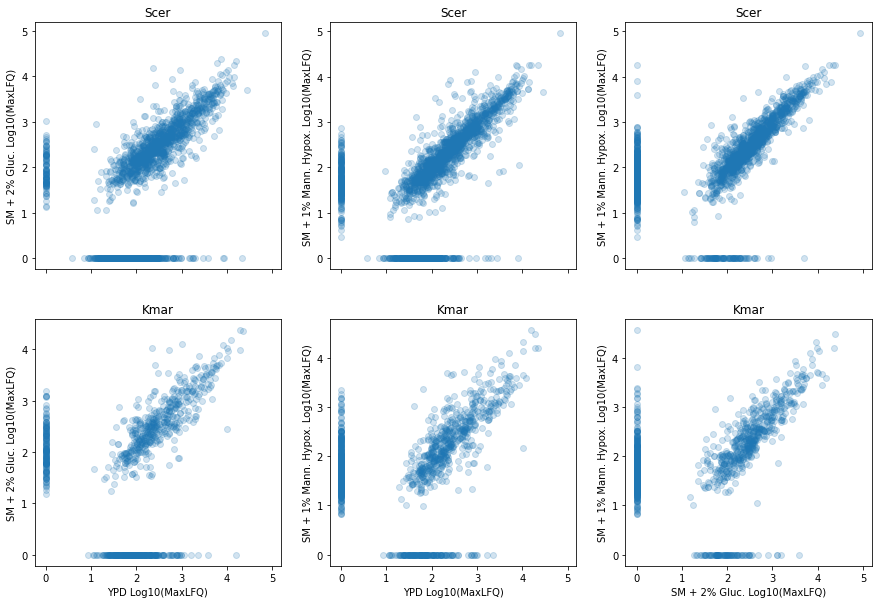

In [12]:


spec = 'Scer'
cond_pairs = [('YPD', 'SM + 2% Gluc.'),('YPD', 'SM + 1% Mann. Hypox.'),('SM + 2% Gluc.', 'SM + 1% Mann. Hypox.')]

fig, axarr = plt.subplots(len(specs),len(cond_pairs), figsize=(15,10), sharex = True)


for jj, spec in enumerate(specs): 
    for kk, (cond1, cond2) in enumerate(cond_pairs): 
            ax = axarr[jj][kk]

            data1 = prot_data[spec][cond1].copy()
            data2 = prot_data[spec][cond2].copy()

            data1.set_index('Genes', inplace=True)
            data2.set_index('Genes', inplace=True)

            data_merged = pd.merge(data1, data2, how='outer',left_index=True, right_index=True, suffixes=['_1','_2'])

            ax.scatter(np.log10(data_merged['Genes.MaxLFQ_1'].fillna(1)), np.log10(data_merged['Genes.MaxLFQ_2'].fillna(1)), alpha = 0.2)
            
            ax.set_title(spec)
            ax.set_ylabel(cond2 + ' Log10(MaxLFQ)')
            if jj==1: 
                ax.set_xlabel(cond1 + ' Log10(MaxLFQ)')
              


In [13]:
prot_data['Scer'][cond]

,File.Name,Genes,Genes.Quantity,Genes.Normalised,Genes.MaxLFQ,Genes.MaxLFQ.Unique,GG.Q.Value,well
2,R:\incoming\_DIA\6600-tof1\Data\30-0008\202010...,AAC3,2516.0500,2338.8200,2338.8200,2338.8200,0.005540,A1
10,R:\incoming\_DIA\6600-tof1\Data\30-0008\202010...,AAC3;PET9,1524.2600,1449.3100,2144.7000,NaN,0.001033,A1
18,R:\incoming\_DIA\6600-tof1\Data\30-0008\202010...,AAP1,10.5628,10.2058,10.2058,10.2058,0.022656,A1
21,R:\incoming\_DIA\6600-tof1\Data\30-0008\202010...,AAP1;APE2,185.2760,168.3730,167.5500,NaN,0.004378,A1
29,R:\incoming\_DIA\6600-tof1\Data\30-0008\202010...,AAT2,287.5630,266.7750,292.2660,292.2660,0.001033,A1
...,...,...,...,...,...,...,...,...
13458,R:\incoming\_DIA\6600-tof1\Data\30-0008\202010...,ZPR1,1868.1400,1809.8000,208.9530,208.9530,0.001033,A1
13466,R:\incoming\_DIA\6600-tof1\Data\30-0008\202010...,ZPS1,73.1292,67.8512,63.8212,63.8212,0.009701,A1
13470,R:\incoming\_DIA\6600-tof1\Data\30-0008\202010...,ZRC1,99.5979,92.4096,92.4096,92.4096,0.006978,A1
13480,R:\incoming\_DIA\6600-tof1\Data\30-0008\202010...,ZUO1,286.1350,260.5820,259.9740,259.9740,0.001033,A1


# Compare expression between species

In [213]:
# Import ortholog map

source = 'Kmar'
target = 'Scer'

orth_map = pd.read_csv(base_dir + os.sep + os.path.normpath('eggnog_mapper/')+ source + '_' + target + '.csv', index_col=0)

orth_map_source = {}



#Read in orf/name file and make it a dictionary
SC_features_fname = os.path.normpath("C:/Users/heineib/Google Drive/Crick_LMS/external_data/genomes/scer_ref/SGD_features.tab")

SC_features = pd.read_csv(SC_features_fname, sep = '\t', header=None)
SGD_orf_lookup = dict(zip(SC_features[0],SC_features[3]))



# Integrate K.mar and S. cer experimental data into ortholog map
conds = list(cond_data.keys())
for cond in conds: 
    
    all_genenames = []
    for gene in prot_data[source][cond]['Genes']:
        gene_split = gene.split(';')
        if len(gene_split)==1: 
            all_genenames.append(gene)
        else: 
             for similar_gene in gene_split:
                all_genenames.append(similar_gene)
    
    
    print('Species: {}, Condition: {}'.format(source,cond))
    
    print('{} unique rows of data for {} genes.'.format(len(set(prot_data['Kmar'][cond]['Genes'])), len(set(all_genenames))))
    
    
    print('{} genes with proteomics data.  {} of those have orthologs in {}.'.format(
           len(set(all_genenames)), 
           len(set(all_genenames) & set(orth_map[source+'_genename'])), 
           target
          ))


    #Build a function that maps expression value to a unique list of genes and flag non-unique data
    
    prot_data_cond = prot_data[source][cond].copy()
    
    exp_map = make_exp_map(prot_data_cond, 'Genes.MaxLFQ')
    
    exp_map.rename(columns = {'Genes.MaxLFQ': source + '_MaxLFQ', 'exp_category': source + '_exp_category'}, inplace=True)
    
    #Integrate data into ortholog map
    orth_map_source[cond] = pd.merge(orth_map, exp_map, left_on='Kmar_genename', right_index=True, how='inner')
    
    
    
    # Check S. cer orthologs and integrate with ortholog map
    #Build a function table (exp_map) that maps expression value to a unique list of genes and flag non-unique data

    prot_data_cond = prot_data[target][cond].copy()
    exp_map_sc = make_exp_map(prot_data_cond, 'Genes.MaxLFQ')
    
    exp_map_sc['Scer_genename'] = sc_seq_functions.SC_orf_lookup_by_name(list(exp_map_sc.index), print_output=False)

    sc_genename_clean = [] # replace SGD name for genes that had those listed instead of ORFs - only a problem because of strange mapping of experimental data to common names and not to standard names 

    for gene in exp_map_sc['Scer_genename']:
        if gene[0:4]=='SGD:':
            sgd_id = gene.split(':')[1]
            sc_genename_clean.append(SGD_orf_lookup[sgd_id])
        else: 
            sc_genename_clean.append(gene)

    exp_map_sc['Scer_genename'] = sc_genename_clean
    
    exp_map_sc.reset_index(inplace=True)
    
    exp_map_sc.rename(columns = {'Genes.MaxLFQ': target + '_MaxLFQ', 'exp_category': target + '_exp_category', 'Genes': 'Scer_common_name'}, inplace=True)
    
    orth_map_source[cond] = pd.merge(orth_map_source[cond], exp_map_sc, left_on='Scer_genename', right_on='Scer_genename', how='inner')
    


Species: Kmar, Condition: YPD
735 unique rows of data for 736 genes.
736 genes with proteomics data.  708 of those have orthologs in Scer.
DBP1already present from non_unique row.  Used first value encountered
PDC6already present from non_unique row.  Used first value encountered
SSA3already present from non_unique row.  Used first value encountered
SSA3already present from non_unique row.  Used first value encountered
SSA3already present from non_unique row.  Used first value encountered
SSA3already present from non_unique row.  Used first value encountered
Species: Kmar, Condition: SM + 2% Gluc.
619 unique rows of data for 622 genes.
622 genes with proteomics data.  595 of those have orthologs in Scer.
ADH2already present from non_unique row.  Used first value encountered
ADH2already present from non_unique row.  Used first value encountered
DBP1already present from non_unique row.  Used first value encountered
SSA3already present from non_unique row.  Used first value encountered
SS

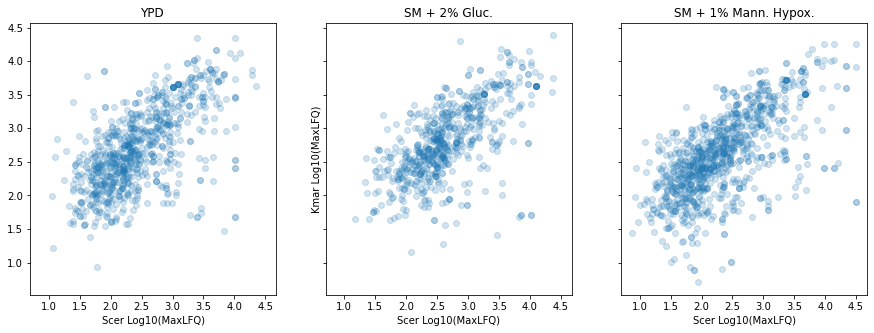

In [214]:
fig, axarr = plt.subplots(1,len(conds), figsize=(15,5), sharex = True, sharey=True)

for jj, cond in enumerate(conds): 
    ax = axarr[jj]
    ax.scatter(np.log10(orth_map_source[cond][source + '_MaxLFQ'].fillna(1)), np.log10(orth_map_source[cond][target + '_MaxLFQ'].fillna(1)), alpha = 0.2)
    ax.set_title(cond)
    if jj==1: 
        ax.set_ylabel(source + ' Log10(MaxLFQ)')
    ax.set_xlabel(target + ' Log10(MaxLFQ)')
              
    

In [184]:
for cond in conds: 
    orth_map_source[cond].to_csv(data_dir + os.sep + os.path.normpath(source + '_' + target + '/' + source + '_' + target + '_' + cond_data[cond]['fname'] + '.csv' ))

## Fold Change between species

In [223]:
cond_pairs = {'YPD_vs_gluc': ('YPD','SM + 2% Gluc.'), 
              'gluc_vs_mann': ('SM + 2% Gluc.', 'SM + 1% Mann. Hypox.')
             }


orth_map_LFC = {}

for cond_pair_name, (cond1, cond2) in cond_pairs.items(): 

    #Find Fold change for each species
    prot_data_merged = pd.merge(prot_data[source][cond1], prot_data[source][cond2], left_on='Genes', right_on='Genes', suffixes = ('_' + cond_data[cond1]['fname'],'_' + cond_data[cond2]['fname'] ), how='inner')
    prot_data_merged['LFC'] = np.log10(prot_data_merged['Genes.MaxLFQ_'+ cond_data[cond2]['fname']])-np.log10(prot_data_merged['Genes.MaxLFQ_' + cond_data[cond1]['fname']])

    prot_data_merged_sc = pd.merge(prot_data[target][cond1], prot_data[target][cond2], left_on='Genes', right_on='Genes', suffixes = ('_' + cond_data[cond1]['fname'],'_' + cond_data[cond2]['fname'] ), how='inner')
    prot_data_merged_sc['LFC'] = np.log10(prot_data_merged_sc['Genes.MaxLFQ_' + cond_data[cond2]['fname']])-np.log10(prot_data_merged_sc['Genes.MaxLFQ_'+ cond_data[cond1]['fname']])



    all_genenames = []
    for gene in prot_data_merged['Genes']:
        gene_split = gene.split(';')
        if len(gene_split)==1: 
            all_genenames.append(gene)
        else: 
             for similar_gene in gene_split:
                all_genenames.append(similar_gene)


    print('Species: {}, LFC Pair: {} vs {}'.format(source,cond2,cond1))

    print('{} unique rows of data for {} genes.'.format(len(set(prot_data_merged['Genes'])), len(set(all_genenames))))

    print('{} genes with proteomics data.  {} of those have orthologs in {}.'.format(
           len(set(all_genenames)), 
           len(set(all_genenames) & set(orth_map[source+'_genename'])), 
           target
          ))


    #Build a function that maps expression value to a unique list of genes and flag non-unique data

    exp_map = make_exp_map(prot_data_merged, 'LFC')

    exp_map.rename(columns = {'LFC': source + '_LFC', 'exp_category': source + '_exp_category'}, inplace=True)

    #Integrate data into ortholog map
    orth_map_LFC[cond_pair_name] = pd.merge(orth_map, exp_map, left_on='Kmar_genename', right_index=True, how='inner')

    # Check S. cer orthologs and integrate with ortholog map
    #Build a function table (exp_map) that maps expression value to a unique list of genes and flag non-unique data

    exp_map_sc = make_exp_map(prot_data_merged_sc, 'LFC')

    exp_map_sc['Scer_genename'] = sc_seq_functions.SC_orf_lookup_by_name(list(exp_map_sc.index), print_output=False)

    sc_genename_clean = [] # replace SGD name for genes that had those listed instead of ORFs - only a problem because of strange mapping of experimental data to common names and not to standard names 

    for gene in exp_map_sc['Scer_genename']:
        if gene[0:4]=='SGD:':
            sgd_id = gene.split(':')[1]
            sc_genename_clean.append(SGD_orf_lookup[sgd_id])
        else: 
            sc_genename_clean.append(gene)

    exp_map_sc['Scer_genename'] = sc_genename_clean

    exp_map_sc.reset_index(inplace=True)

    exp_map_sc.rename(columns = {'LFC': target + '_LFC', 'exp_category': target + '_exp_category', 'Genes': 'Scer_common_name'}, inplace=True)

    orth_map_LFC[cond_pair_name] = pd.merge(orth_map_LFC[cond_pair_name], exp_map_sc, left_on='Scer_genename', right_on='Scer_genename', how='inner')













#Scatter plots between species

#Fold Change between species

#Map genenames to normal names



# Map K.mar expression onto ortholog map

# Map S. cer expression onto ortholog map

# Plot based on type of ortholog


Species: Kmar, LFC Pair: SM + 2% Gluc. vs YPD
473 unique rows of data for 478 genes.
478 genes with proteomics data.  467 of those have orthologs in Scer.
ADH2already present from non_unique row.  Used first value encountered
ADH2already present from non_unique row.  Used first value encountered
DBP1already present from non_unique row.  Used first value encountered
PDC6already present from non_unique row.  Used first value encountered
SSA3already present from non_unique row.  Used first value encountered
SSA3already present from non_unique row.  Used first value encountered
SSA3already present from non_unique row.  Used first value encountered
SSA3already present from non_unique row.  Used first value encountered
Species: Kmar, LFC Pair: SM + 1% Mann. Hypox. vs SM + 2% Gluc.
532 unique rows of data for 535 genes.
535 genes with proteomics data.  515 of those have orthologs in Scer.
ADH2already present from non_unique row.  Used first value encountered
ADH2already present from non_uniqu

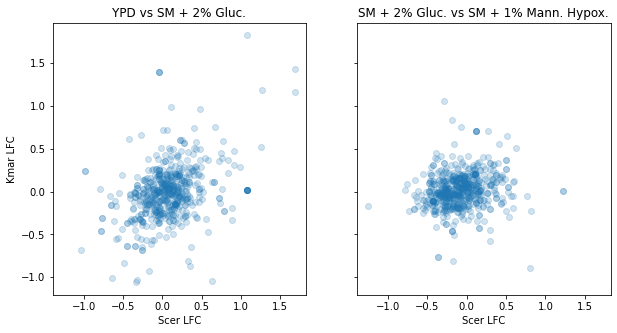

In [226]:
fig, axarr = plt.subplots(1,len(cond_pairs.keys()), figsize=(10,5), sharex = True, sharey=True)

for jj, (cond_pair_name, (cond1, cond2)) in enumerate(cond_pairs.items()): 
    ax = axarr[jj]
    ax.scatter(orth_map_LFC[cond_pair_name][source + '_LFC'].fillna(0), orth_map_LFC[cond_pair_name][target + '_LFC'].fillna(0), alpha = 0.2)
    ax.set_title(cond1 + ' vs ' + cond2)
    if jj==0: 
        ax.set_ylabel(source + ' LFC')
    ax.set_xlabel(target + ' LFC')

In [198]:
prot_data_merged = pd.merge(prot_data[source][cond1], prot_data[source][cond2], left_on='Genes', right_on='Genes', suffixes = ('_' + cond_data[cond1]['fname'],'_' + cond_data[cond2]['fname'] ), how='inner')

In [227]:
for cond_pair_name, (cond1, cond2) in cond_pairs.items(): 
    orth_map_LFC[cond_pair_name].to_csv(data_dir + os.sep + os.path.normpath(source + '_' + target + '/' + source + '_' + target + '_' + cond_pair_name + '.csv' ))

In [154]:



# SC_orfs = SC_features.groupby(1).get_group('ORF')

# #Makes a dictionary to look up orfs by gene names.  This won't include all orfs - those without names had NaN in column 4 so 
# #are presumably left out. 
# SC_orfs_lookup = dict(zip(SC_orfs[4], SC_orfs[3]))
# SC_genename_lookup = dict(zip(SC_orfs[3], SC_orfs[4]))
# SC_features_lookup = dict(zip(SC_orfs[3], SC_orfs[15]))

,Scer_MaxLFQ,Scer_exp_category,sc_common_name,sc_genename
Genes,,,,
AAC3,5449.7800,unique_non_unique,YBR085W,YBR085W
AAT2,456.7860,unique,YLR027C,YLR027C
ABF2,490.5070,unique,YMR072W,YMR072W
ABP1,381.5760,unique,YCR088W,YCR088W
ACB1,788.6570,unique,YGR037C,YGR037C
...,...,...,...,...
COB,144.4280,non_unique,Q0105,Q0105
YRF1-2,59.7496,non_unique,YER190W,YER190W
YRF1-3,59.7496,non_unique,YGR296W,YGR296W


['SGD:S000000132',
 'SGD:S000000182',
 'SGD:S000000257',
 'SGD:S000000260',
 'SGD:S000000343',
 'SGD:S000000491',
 'SGD:S000000547',
 'SGD:S000000609',
 'SGD:S000000686',
 'SGD:S000000746',
 'SGD:S000000812',
 'SGD:S000000936',
 'SGD:S000000958',
 'SGD:S000001062',
 'SGD:S000001164',
 'SGD:S000001180',
 'SGD:S000001245',
 'SGD:S000001370',
 'SGD:S000001552',
 'SGD:S000001574',
 'SGD:S000001726',
 'SGD:S000001902',
 'SGD:S000001912',
 'SGD:S000001914',
 'SGD:S000002244',
 'SGD:S000002282',
 'SGD:S000002303',
 'SGD:S000002468',
 'SGD:S000002670',
 'SGD:S000002749',
 'SGD:S000002884',
 'SGD:S000003007',
 'SGD:S000003069',
 'SGD:S000003211',
 'SGD:S000003244',
 'SGD:S000003253',
 'SGD:S000003286',
 'SGD:S000003343',
 'SGD:S000003362',
 'SGD:S000003442',
 'SGD:S000003482',
 'SGD:S000003498',
 'SGD:S000003591',
 'SGD:S000003604',
 'SGD:S000003707',
 'SGD:S000003857',
 'SGD:S000003903',
 'SGD:S000004169',
 'SGD:S000004247',
 'SGD:S000004337',
 'SGD:S000004544',
 'SGD:S000004600',
 'SGD:S00000

In [122]:
len(set(orth_map_source[cond]['Kmar_genename']))

910

In [ ]:

fig, ax = plt.subplots(1,len(specs), figsize=(12,8))


for jj, spec in enumerate(specs): 
    ax = axarr[jj]
    genenames = {}
    for cond in conds: 
        data = prot_data[spec][cond]
        genenames[cond] = set(list(data['Genes']))
    venn(genenames, ax=ax)
    ax.set_title(spec)

In [17]:
len(set(prot_data['Km'][cond]['Genes']) & set(orth_map['Kmar_genename']))

890

,Unnamed: 0,Kmar_genename,Scer_genename,orth_type
0,0,NC_036025.1:208208-210287(-)_1,YNL272C,one2one
1,1,NC_036025.1:261454-262873(-)_1,YGR255C,one2one
2,2,NC_036025.1:345826-347974(+)_1,YDR485C,one2one
3,3,NC_036025.1:434487-435090(+)_1,YGR078C,one2one
4,4,NC_036025.1:461368-462350(-)_1,YLR288C,one2one
...,...,...,...,...
5309,5309,NC_036030.1:295857-296164(-)_1,YBR009C,many2many
5310,5310,NC_036030.1:295857-296164(-)_1,YNL030W,many2many
5311,5311,NC_036032.1:159679-160675(-)_1,YGR192C,many2many
5312,5312,NC_036032.1:159679-160675(-)_1,YJL052W,many2many
